First we need to define the model:

$$ H = \sum_{n = 1}^{N - 1} [J_{n} ( \hat{\sigma}_{n}^{x}\hat{\sigma}_{n+1}^{x} + \hat{\sigma}_{n}^{y}\hat{\sigma}_{n+1}^{y}) + \Delta_{n} \hat{\sigma}_{n}^{z}\hat{\sigma}_{n+1}^{z}] $$

With $J_{n}$ and $\Delta_{n}$ given as:

- $J_{n} = J_{L}, \Delta_{n} = \Delta_{L}$ for $n < N/2$
- $J_{N/2} = J_{M}, \Delta_{N/2} = \Delta_{M}$
- $J_{n} = J_{R}, \Delta_{n} = \Delta_{R}$ for $n > N/2$

Note: We will consider N as even number.



In [13]:
using LinearAlgebra
using Base
using Plots
using LaTeXStrings

In [14]:
# Matrix Representations and kroenecker products:
Sigma_x = [0 1; 1 0]
Sigma_y = [0 -1im; 1im 0]
Sigma_z = [1 0; 0 -1]

Identity = [1 0; 0 1] #or Using LinearAlgebra and Matrix{Float64}(I, 2, 2)

function S_Term(N, cte_list, SigmaMatrix)
    # I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I: Sigma can be Sigmax, Sigmay or Sigmaz.
    # cte_list = [cte_L, cte_M, cte_R], can be J or ∆.

    Matrix_Sigma = zeros(2^N, 2^N)

    cte_L = cte_list[1]
    cte_M = cte_list[2]
    cte_R = cte_list[3]    
    
    for i=1:N-1
        M = Identity
        
        if i == 1
            M = SigmaMatrix
        end
       
        M = M 

        for j=2:N 
            if j == i || j == i + 1
            M = kron(M, SigmaMatrix)
            else
            M = kron(M, Identity)        
            end
        end 

        if i < N/2
            cte = cte_L
        elseif i > N/2
            cte = cte_R
        else
            cte = cte_M
        end        

        Matrix_Sigma = Matrix_Sigma + M*cte #cte can be ∆_i or J_i
    end

    return Matrix_Sigma #∑ I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I
end


function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I: Convert local operators into global operators.
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Correlation_Matrix_site_i_j(i,j,N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I⊗M⊗I⊗I...⊗I
    
    M = Identity
    
    if j == 1 || i == 1
        M = matrix
    end    
    
    for k=2:N 
        if k == j
        M = kron(M, matrix)
        elseif k == i
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Correlation_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M⊗I...⊗I⊗M⊗I⊗I...⊗I
    
    M = Identity
    
    if j == 1 
        M = matrix_j
    end    

    if i == 1 
        M = matrix_i
    end        
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Correlation_Matrix_i_Matrix_j (generic function with 1 method)

In [15]:
Correlation_Matrix_site_i_j(1,2,3, Sigma_x)

8×8 Matrix{Int64}:
 0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  1
 0  0  0  0  1  0  0  0
 0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0
 0  0  0  1  0  0  0  0
 1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0

In [16]:
function Build_Hamiltonian(N, delta_list, J_list)
    # H = ∑ I⊗...⊗I⊗JSx⊗Sx⊗I...⊗I + I⊗...⊗I⊗JSy⊗Sy⊗I...⊗I + I⊗...⊗I⊗ΔSz⊗Sz⊗I...⊗I
    
    H = S_Term(N, J_list, Sigma_x) + S_Term(N, J_list, Sigma_y) + S_Term(N, delta_list, Sigma_z)
    return H
end
    
function Exact_Diagonalization(N, delta)    

    H = Build_Hamiltonian(N, delta)
    return eigen(H).values, eigen(H).vectors #Eigenvalues and Eigenvectors of H
end 

function Exact_expected_value_global_operator(state, operator)
    # <Ψ | O | Ψ > 
    
    if (length(state), length(state)) != size(operator)
        return "Error. Different Dimensions."
    end 
    return transpose(state)*operator*state
end

function Exact_expected_value_local_operator_site_j(state, operator, j)
    # <Ψ | O_j | Ψ > 
    
    Matrix = Enlarge_Matrix_site_j(j, log2(length(state)), operator) #N = log2(length(state))
    return transpose(state)*Matrix*state
end

Exact_expected_value_local_operator_site_j (generic function with 1 method)

In [17]:
function Build_Liouvillian_Superoperator(H, lambda_list, gamma)
    #lambda_list = [λ1, λ2, ..., λN]

    N = length(lambda_list)

    superIdentity = Enlarge_Matrix_site_j(1, N, Identity)
    
    superH = -1im*(kron(superIdentity, H) - kron(transpose(H), superIdentity))
    superL = zeros(size(superH))
    
    for k=1:N
        #First we need to build L_k

        #contribution from sigma_plus
        L_k = (Enlarge_Matrix_site_j(k, N, Sigma_x) + 1im*Enlarge_Matrix_site_j(k, N, Sigma_y))/2
        gamma_k = lambda_list[k]*gamma
        
        superL = superL + gamma_k*(kron(conj(L_k), L_k) -0.5*(kron(superIdentity, adjoint(L_k)*L_k) + kron(transpose(L_k)*conj(L_k), superIdentity)))

        #contribution from sigma_minus
        L_k = adjoint((Enlarge_Matrix_site_j(k, N, Sigma_x) + 1im*Enlarge_Matrix_site_j(k, N, Sigma_y)))/2
        gamma_k = (1 - lambda_list[k])*gamma

        superL = superL + gamma_k*(kron(conj(L_k), L_k) -0.5*(kron(superIdentity, adjoint(L_k)*L_k) + kron(transpose(L_k)*conj(L_k), superIdentity)))
    end

    Liouvillian_Superoperator = superH + superL

    return Liouvillian_Superoperator
end

Build_Liouvillian_Superoperator (generic function with 1 method)

In [18]:
Build_Hamiltonian(2, [1,2,3], [1,2,3])

4×4 Matrix{ComplexF64}:
 2.0+0.0im   0.0+0.0im   0.0+0.0im  0.0+0.0im
 0.0+0.0im  -2.0+0.0im   4.0+0.0im  0.0+0.0im
 0.0+0.0im   4.0+0.0im  -2.0+0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im   0.0+0.0im  2.0+0.0im

In [19]:
N = 4

deltaL_over_JL_values = LinRange(-8,8,10) #(∆_L/J_L)

Currents_reverse = []
Currents_forward = []

for value=deltaL_over_JL_values #(∆_L/J_L)

    J_list = [1,1,1] #J_L = J_R = J_M = 1
    delta_list = [value*J_list[1],0,0] # ∆_L = (∆_L/J_L)*J_L
    
    H = Build_Hamiltonian(N, delta_list, J_list)
    
    Sigma_plus = (Sigma_x +1im*Sigma_y)/2
    Sigma_minus = adjoint(Sigma_plus)
    
    lambda_list = [0,0,0,0.5] #reverse
            
    Liouvillian_Superoperator = Build_Liouvillian_Superoperator(H, lambda_list, 1)  #gamma = J_L/hbar = 1  
    # EigVals, EigVectors = eigen(Liouvillian_Superoperator).values, eigen(Liouvillian_Superoperator).vectors
    # GS = EigVectors[:, indexin(minimum(abs.(EigVals)), abs.(EigVals))]

    GS = nullspace(Liouvillian_Superoperator)
    rho_ss = reshape(GS, size(H)) #Steady State
    rho_ss = rho_ss./tr(rho_ss)
    
    Current_operator = 2*J_list[1]*(Correlation_Matrix_i_Matrix_j(1,2,N, Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(1,2,N, Sigma_y, Sigma_x))
    
    Current =  real.(tr(Current_operator*rho_ss))
    append!(Currents_reverse , Current)

    lambda_list = [0.5,0,0,0] #forward
            
    Liouvillian_Superoperator = Build_Liouvillian_Superoperator(H, lambda_list, 1)  #gamma = J_L/hbar = 1  
    # EigVals, EigVectors = eigen(Liouvillian_Superoperator).values, eigen(Liouvillian_Superoperator).vectors
    # GS = EigVectors[:, indexin(minimum(abs.(EigVals)), abs.(EigVals))]

    GS = nullspace(Liouvillian_Superoperator)
    rho_ss = reshape(GS, size(H)) #Steady State
    rho_ss = rho_ss./tr(rho_ss)
    
    Current_operator = 2*J_list[1]*(Correlation_Matrix_i_Matrix_j(1,2,N, Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(1,2,N, Sigma_y, Sigma_x))
    
    Current =  real.(tr(Current_operator*rho_ss))
    append!(Currents_forward , Current)
end

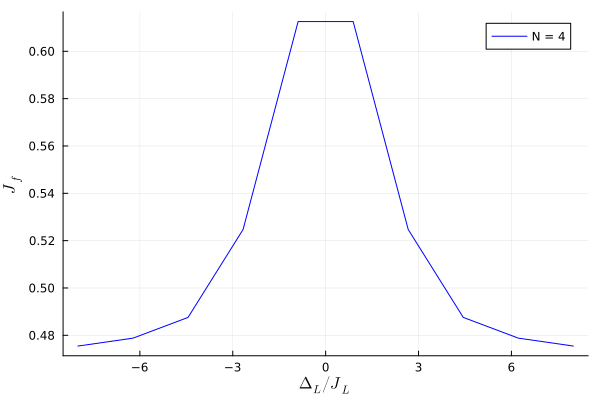

In [20]:
plot(deltaL_over_JL_values,real.(Currents_forward), xlabel = L"\Delta_{L} / J_{L}", ylabel = L"J_{f}", color = "blue", label = "N = 4")

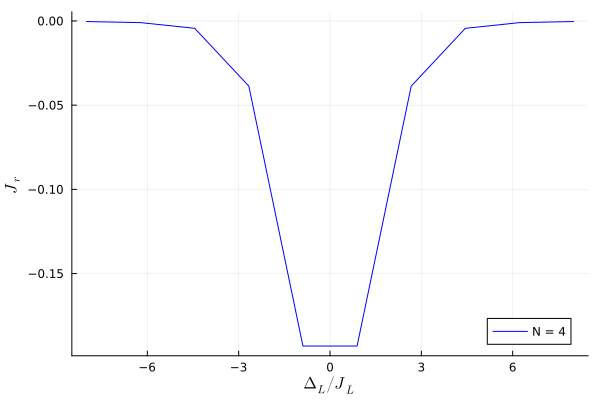

In [21]:
plot(deltaL_over_JL_values,real.(Currents_reverse), xlabel = L"\Delta_{L} / J_{L}", ylabel = L"J_{r}", color = "blue", label = "N = 4")

In [22]:
R = -Currents_forward./Currents_reverse

C = (Currents_forward + Currents_reverse)./(Currents_forward - Currents_reverse)

10-element Vector{Float64}:
 0.9986185319481644
 0.9959441088724473
 0.9823353291351806
 0.8626943806542
 0.5207698249433808
 0.5207698249433812
 0.8626943806541942
 0.9823353291351828
 0.9959441088724454
 0.9986185319481612

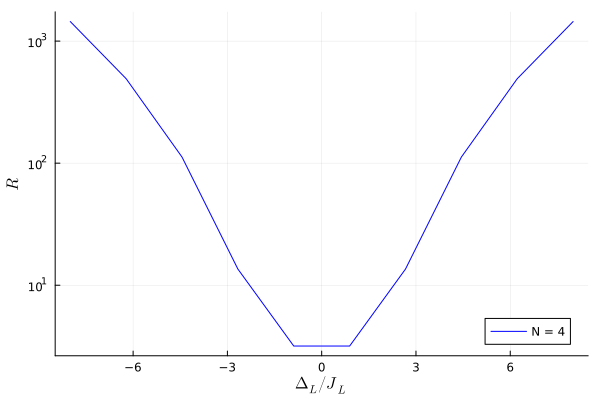

In [23]:
plot(deltaL_over_JL_values,R, xlabel = L"\Delta_{L} / J_{L}", ylabel = L"R", yscale=:log10, color = "blue", label = "N = 4")

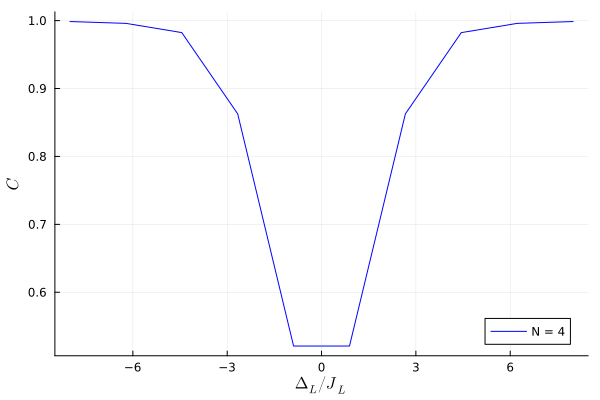

In [24]:
plot(deltaL_over_JL_values,C, xlabel = L"\Delta_{L} / J_{L}", ylabel = L"C", color = "blue", label = "N = 4")